In [1]:
import torch
from fastai.vision.all import *
import os

if torch.cuda.is_available():
    print("CUDA is available on this system.")
else:
    print("CUDA is NOT available on this system.")

/home/ippen/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available on this system.


In [2]:
# Fix Display behavior in Jupyter Notebooks for VS Code
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [3]:
def get_state_label(file_path, labels_file):
    file_name = os.path.basename(file_path)
    # Extract the state label from the filename
    with open(labels_file, "r") as f:
        labels_data = json.load(f)
    tl = labels_data[file_name]
    return tl["state"]

def get_pictogram_label(file_path, labels_file):
    file_name = os.path.basename(file_path)
    # Extract the state label from the filename
    with open(labels_file, "r") as f:
        labels_data = json.load(f)
    tl = labels_data[file_name]
    return tl["pictogram"]

In [12]:
dataset_path = "/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_tl_combined/"
train_folder = 'train'
valid_folder = 'valid'

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock, CategoryBlock),
                   n_inp=1,
                   get_items=get_image_files,
                   get_y=[lambda file_path: get_state_label(file_path, dataset_path + '/labels.json'),lambda file_path: get_pictogram_label(file_path, dataset_path + '/labels.json')],
                   item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'),
                   batch_tfms=None)

In [13]:
dls = dblock.dataloaders(dataset_path, path=dataset_path, train=train_folder, valid=valid_folder, bs=64)

In [14]:
print("Train size: " + str(len(dls.train.items))+ " | Valid size: " + str(len(dls.valid.items)))

Train size: 17280 | Valid size: 4319


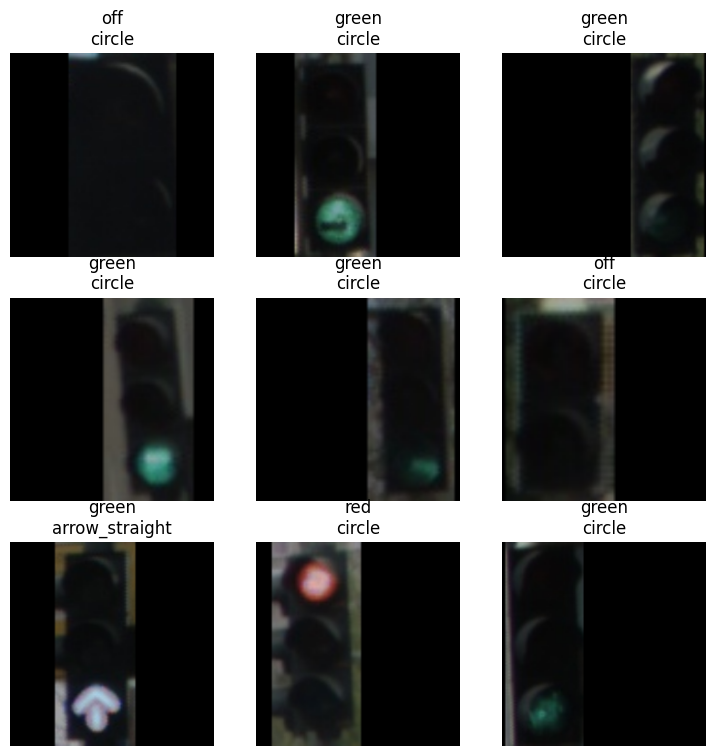

In [15]:
dls.show_batch(max_n=9)

In [16]:
def state_loss(inp,state,pictogram): return F.cross_entropy(inp[:,:5],state)
def pictogram_loss(inp,state,pictogram): return F.cross_entropy(inp[:,5:],pictogram)

In [17]:
def combine_loss(inp, state, pictogram): return state_loss(inp, state, pictogram) + pictogram_loss(inp, state, pictogram)

In [18]:
def state_err(inp,state,pictogram): return error_rate(inp[:,:5],state)
def pictogram_err(inp,state,pictogram): return error_rate(inp[:,5:],pictogram)

err_metrics = (state_err, pictogram_err)

In [19]:
all_metrics = err_metrics + (state_loss, pictogram_loss)

In [20]:
learn = vision_learner(dls, resnet18, loss_func=combine_loss, metrics=all_metrics, n_out=9)

/home/ippen/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ippen/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
learn.fine_tune(5, 4e-3)

epoch,train_loss,valid_loss,state_err,pictogram_err,state_loss,pictogram_loss,time
0,0.217148,0.179552,0.014587,0.031720,0.056917,0.122635,01:24
1,0.161229,0.076605,0.009261,0.013429,0.029743,0.046862,01:25
2,0.084537,0.073781,0.006483,0.012271,0.025874,0.047907,01:27
3,0.037682,0.061687,0.007409,0.009261,0.026898,0.034789,01:58
4,0.017244,0.055285,0.006715,0.008104,0.026616,0.028669,01:57


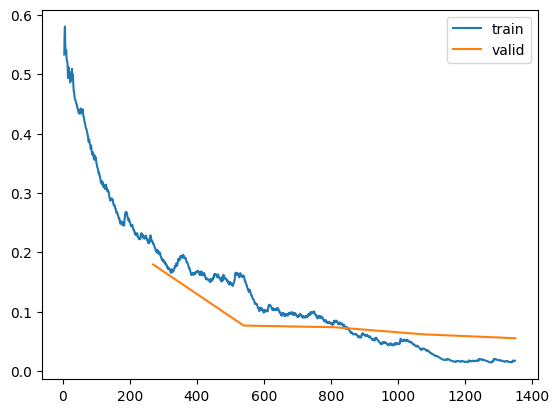

In [22]:
learn.recorder.plot_loss()

In [23]:
learn.save('tl_v2')

Path('/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_tl_combined/models/tl_v2.pth')

In [25]:
folder_path = "/home/ippen/personal/traffic-light-classification/datasets/samples"

# Get a list of all image files in the folder
image_files = get_image_files(folder_path)

# Define the cropping transformation
crop_transform = Resize(224, ResizeMethod.Pad, pad_mode='zeros')
img = PILImage.create(image_files[0])

# Apply the cropping transformation to the image
cropped_img = crop_transform(img)

# Use the learner to predict the cropped image
prediction = learn.predict(cropped_img, with_input=True)
prediction

AssertionError: Match length mismatch

In [24]:
learn.show_results()


AssertionError: Match length mismatch